# 3.05 

* Weather Period from 1.8.2019 to 28.8.2019




In [153]:
from pyknon.genmidi import Midi
from pyknon.music import Rest, Note, NoteSeq
from music_generation import*
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from datetime import date

### Read Meteo data

In [154]:
def read_meteo_data(fName):
    colNames = ['Stao','time', 'T_Boden_20cm', 'Flash_30km', 'Glob_rad', 'QFE','T_2m','Rain_Sum','H_rel','visibi','V_wind','direction_wind']  
    df = pd.read_csv(fName,sep=';', skiprows=3, names=colNames, na_values='-')
    print(df.head())
    return df

fPath = '/mnt/daten/04_Schule/42_Kanti/Matrua/Music_generation/Organisation/MeteoSchweiz/Daten/'
fName = 'order_75330_data.txt'
dM = read_meteo_data(fPath+fName)

NT, MP = dM.shape

  Stao          time  T_Boden_20cm  Flash_30km  Glob_rad    QFE  T_2m  \
0  KLO  201908010000          21.5           0         2  969.5  15.3   
1  KLO  201908010010          21.5           0         2  969.5  14.9   
2  KLO  201908010020          21.5           0         2  969.5  14.6   
3  KLO  201908010030          21.5           0         2  969.5  14.6   
4  KLO  201908010040          21.4           0         2  969.6  13.7   

   Rain_Sum  H_rel   visibi  V_wind  direction_wind  
0       0.0   80.4  20000.0     0.9             117  
1       0.0   82.4  20000.0     1.1              98  
2       0.0   83.7  20000.0     1.0             121  
3       0.0   82.7  20000.0     1.2             119  
4       0.0   88.8  20000.0     1.0             173  


### Chords and scales

In [155]:
C     = np.array([ 0, 4, 7])
Cm    = np.array([ 0, 3, 7])
Cdim  = np.array([ 0, 3, 6])

CM7   = np.array([ 0, 4, 7, 11])
C7    = np.array([ 0, 4, 7, 10])
Cm7   = np.array([ 0, 3, 7, 10])
Cdim7 = np.array([ 0, 3, 6, 10])
Cdim6 = np.array([ 0, 3, 6, 9 ])
C6    = np.array([ 0, 4, 7, 9 ]) # inversion of Am7
Cm6   = np.array([ 0, 3, 7, 9 ])

Csus4 = np.array([ 0, 5, 7])
Csus2 = np.array([ 0, 2, 7])
Csus47= np.array([ 0, 5, 7, 10])

P = np.array([ 0,7])  # Power chord (Perfect unison, Perfect fifth)
B = np.array([ 0])    # Bass (Perfect unison)

major = np.array([ 0, 2, 4, 5, 7, 9, 11])
minor = np.array([ 0, 2, 3, 5, 7, 8, 10])
blues = np.array([ 0, 3, 5, 6, 7, 10])

### Drum

* together with __on_off__ and __met_vol__ it repleaces __met_percus__ of the previos version
* Creates a regular drumm track by definig a rythmic, note and volume pattern
* the volumes will be corrected by the on_off function
* the volume can be overwritten be the __met_vol__ function


In [156]:
def drum(rythems,notes,volumes,melody_len):
    ryth_rep = int((melody_len/(np.sum(rythems)*4))+1)      # calculate repeat factor
    rythem = np.tile(rythems,ryth_rep)                      # tile  
    rythem = np.delete(rythem, np.argwhere(np.cumsum(rythem)*4 >= melody_len))  # delete not used notes
    note_nr = len(rythem)
    
    melody_rep = int(note_nr/len(notes)+1)      # calculate repeat factor
    melody = np.tile(notes,melody_rep)          # tile  
    melody = melody[:note_nr]                   # delete not used notes
    
    volume_rep = int(note_nr/len(volumes)+1)    # calculate repeat factor
    volume = np.tile(volumes,volume_rep)        # tile  
    volume = volume[:note_nr]                   # delete not used notes

    return melody, rythem, volume
   

### Meteo Volume
* Generates out of meteo data a Volume track
* uses the Rytehm to calculate the position in the meteo data
* volumes can be in or decreased by a value (add)
* maximum value is 127 as this is the maximum MIDI-Volume

In [157]:
def met_vol(meteo, add, rythem, mpb):
    met_resolution = 10 
    cum_ryth = np.concatenate((np.asarray([0]),np.cumsum(rythem)))[:-1]   # add 0 at beginig remove last element
    i_data = (cum_ryth * (mpb /met_resolution)).astype(int)               # calculate index of the data
    volumes = meteo[i_data].astype(int)                 # fill in meteo data
    volumes = volumes + add                             # add 
    volumes = np.minimum(volumes, 127)                  # set values bigger than 127 to 127
    return volumes

### on_off

* Mutes and unmutes voices dependet of the meteo input data
* With on_range defines when a voice plays
* on_off is applied after the met_transform. so the on_range must be adjusted accordingly


In [158]:
def on_off(meteo, on_range, volumes, rythem, mpb):
    met_resolution = 10 
    cum_ryth = np.concatenate((np.asarray([0]),np.cumsum(rythem)))[:-1]   # add 0 at beginig remove last element
    i_data = (cum_ryth * (mpb /met_resolution)).astype(int)               # calculate index of the data

    for npn in range(len(i_data)):                  
        value = meteo[ i_data[npn] ]                  # get value of the meteo data
        if on_range[0] < value < on_range[1]: pass    # do nothing when in on_range
        else:  volumes[npn] = 0                       # set volume to zero when out of range
    
    return volumes
#volumes3 = on_off(trans[5],[0.1,200000],volumes3, rythem3, mpb)

### Print Start and End
* Prints the end and starting point of the actual tune
* Calculates melody_len and Start

In [159]:
def print_dur(bar,bpb,mpb,s_day,s_hour,tune_name):
    start = (s_day*24)+ s_hour  # start in hours 
    melody_len = bar * bpb
    
    S_h = start%24
    S_d = start//24
    dur_h = melody_len *mpb/60
    E_h = (start+dur_h)%24
    E_d = (start+dur_h)//24
    print(tune_name+': Start:',S_d,'day',S_h,'h   End:', E_d,'day',E_h,'h')
    
    return melody_len, start
    

## tune 304_A

* this tune is similar to the previous one. but the Function used where changed and improved
* period from 5.8 to 7.8.2019


In [182]:
def tune_304_A():
    tune_name = 'tune_304_A'  
    #np.random.seed(56)
    bar, bpb      = 15, 4     # bar: Takt , bpb: beat per bar
    s_day, s_hour = 4, 18   # Start point in the data
    mpb     =  60            # minutes per beat
    end_dur =  0
    melody_len, start = print_dur(bar,bpb,mpb,s_day,s_hour,tune_name)

    trans = met_transform(dM,[1,1,1,4,1.3,400,0.2,1,4.5,1,],[6,6,6,6,6,24,6,6,6,2],start)

    scales = [[8,'C',major]]
    end_scale = [[1,'C',P]]
    pattern = pattern_gen(scales, end_scale, melody_len)

    # Pressure
    range_1 = liniar_range(0,0,0,0)
    rythem1, notenr_1 = ran_duration([1/32,1/8, 1/4,1/2], [0,2,3,1], melody_len, end_dur)
    melody1 = meteo_melody(trans[3],pattern, 60, range_1, notenr_1, rythem1,mpb)
    volumes1 = ran_volume([0,100], [1,8], notenr_1 )
    notes1 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody1,rythem1,volumes1)] )
    
    # temp
    range_2 = liniar_range(0,0,0,0)
    rythem2, notenr_2 = ran_duration([1/16,1/8, 1/4,1/2], [0,2,3,2], melody_len, end_dur)
    melody2 = meteo_melody(trans[4],pattern, 80, range_2, notenr_2, rythem2,mpb)
    volumes2 = ran_volume([0,100], [1,8], notenr_2 )
    notes2 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody2,rythem2,volumes2)] )
    
    #timpani rain
    melody3, rythem3, volumes3 = drum([1/16,1.5/16], [60,63,66],[100,127],melody_len) 
    volumes3 = met_vol(trans[5],0,rythem3, mpb)
    notes3 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody3,rythem3,volumes3)] )

    instruments = [48,48,47]
    notes = [notes1,notes2,notes3]
    return notes, instruments,tune_name

__Instruments:__
Available are at lest the 128 General-Midi (GM) Instruments. Depending on the sound-fonts there is a bigger choise. A list of the GM instruments can be found here. https://jazz-soft.net/demo/GeneralMidi.html


## Generate Midi and Audio file

In [183]:
def gen_midi():
#     squezze into a MIDI framework
    notes, instruments, tune_name = tune_304_A() #  <--- select a tune  <<--     <<<<<<<<<--- select a tune -----
    nTracks = len(notes)
    
    m = Midi(number_tracks=nTracks, tempo=120, instrument=instruments)
    for iTrack in range(nTracks):
        m.seq_notes(notes[iTrack], track=iTrack)

    #--- write the MIDI file -----
    midi_file_name = tune_name +'.mid'   # set the name of the file
    m.write(midi_file_name)
    return midi_file_name

tune_304_A: Start: 4 day 18 h   End: 7.0 day 6.0 h


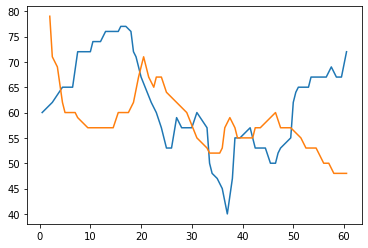

In [184]:
######---  Main  ---######
midi_file_name = gen_midi()

midi_play(midi_file_name)
midi_audio(midi_file_name)
midi_png(midi_file_name)


### External __Music_Generation__ library
This library changes from version to version. New or changed code is first explaind above. This is a copy of music_generation.py 